In [33]:
%pip install mne xgboost tensorflow scikit-learn pandas numpy matplotlib scipy tqdm


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, classification_report, cohen_kappa_score)
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tqdm import tqdm
import warnings
from scipy import signal
warnings.filterwarnings('ignore')

In [35]:
def load_emotion_data(data_dir):                                                        # Emotion icin veri setini yukluyoruz.
    file_pairs = []
    
    for f in os.listdir(data_dir):                                                      # Dosya eslestirme islemi yapiyoruz.
        if f.endswith('.set'):
            events_file = f.replace('_eeg.set', '_events.tsv')                          # Set dosyasi ham sinyalleri tutar, tsv dosyasi eventleri tutar.
            events_path = os.path.join(data_dir, events_file)
            if os.path.exists(events_path):
                file_pairs.append((
                    os.path.join(data_dir, f),
                    events_path
                ))
            else:
                print(f"Event dosyası bulunamadı: {events_path}")
    
    print(f"Bulunan EEG-Event çiftleri: {len(file_pairs)}")
    for pair in file_pairs:
        print(f"  {pair[0]} - {pair[1]}")
    return file_pairs


In [36]:
from scipy.stats import skew, kurtosis, entropy

def extract_emotion_features(data, sfreq):                                  # Sinyallere ait ozellikleri burada cikartiyoruz. data: np.array, shape (n_epochs, n_channels, n_times), sfreq: ornekleme hizi (Hz)

    feature_list = []   
    count=0                                                                 # Islenen toplam epoch sayisi.

    for epoch in data:                                                      # Her epoch icin dongu donuyoruz ve featurelarini cikartiyoruz.
        feats = []
        for ch_signal in epoch:                                             # Her kanal icin dongu

            mean = np.mean(ch_signal)                                       # Ortalama
            median = np.median(ch_signal)                                   # Medyan
            variance = np.var(ch_signal)                                    # Varyans
            min_val = np.min(ch_signal)                                     # Minimum deger
            max_val = np.max(ch_signal)                                     # Maksimum deger
            ptp = max_val - min_val                                         # Tepe araligi
            
            feats.extend([mean, median, variance, min_val, max_val, ptp])
            
            autocorr = np.correlate(ch_signal, ch_signal, mode='full')[len(ch_signal)-1:len(ch_signal)+5]       # Ilk 5 gecikme icin otokorelasyon degerleri
            feats.extend(autocorr[1:6])
            
            t = np.arange(len(ch_signal))                                   # Zaman vektoru
            slope = np.polyfit(t, ch_signal, 1)[0]                          # Egim hesabi
            feats.append(slope)
            
            hist, _ = np.histogram(ch_signal, bins=10, density=True)        # Entropi hesabi
            ent = entropy(hist)
            feats.append(ent)
            
            rms = np.sqrt(np.mean(ch_signal**2))                            # Root Mean Square frekans hesabi
            feats.append(rms)
            
            zcr = np.sum(np.diff(np.sign(ch_signal)) != 0) / len(ch_signal)     # Zero Crossing Rate hesabi
            feats.append(zcr)
            
            s = skew(ch_signal)                                            # Skewness ve kurtosis hesabi
            k = kurtosis(ch_signal)
            feats.extend([s, k])
            
            count+=1
        feature_list.append(feats)

    print (f"Özellik çıkarımı için toplam {count} epoch işleniyor...")
    return np.array(feature_list)

In [37]:
"""label_mapping = {
    'ibeg': 0, 'iend': 1, 'rsrt': 2, 'fixl': 3,
    'quiz': 4, 'qdon': 5, 'base': 6, 'bend': 7, 'trno': 8,
    'fixL': 9, 'stm': 10, 'clic': 11, 'vlnc': 12, 'arsl': 13,
    'dmns': 14, 'lkng': 15, 'fmrt': 16, 'relv': 17, 'cate': 18,
    'IBEG': 19, 'IEND': 20, 'puse': 21, 'boundary': 22, 'stop': 23,
    'baseline': 24,'baseend': 25,'trialno': 26,'fixation loop': 27,
    'neutral_1_1': 28,'valence': 29,'arousal': 30,'dominance': 31,'liking': 32,
    'familiarity': 33,'relevance': 34,'3_2': 35,'click': 36,
    'impedances begin': 37,'emotion_categ': 38,'impedances end': 39,'stop event': 40
}"""
label_mapping = {                                                                               # Bazilari digerlerinin kucuk harfle yazilmis hali, onlari birlestirdim.
    'ibeg': 0, 'iend': 1, 'rsrt': 2, 'fixl': 3,
    'quiz': 4, 'qdon': 5, 'base': 6, 'bend': 7, 'trno': 8,
    'fixL': 9, 'stm': 10, 'clic': 11, 'vlnc': 12, 'arsl': 13,
    'dmns': 14, 'lkng': 15, 'fmrt': 16, 'relv': 17, 'cate': 18,
    'IBEG': 0, 'IEND': 1, 'puse': 19, 'boundary': 20, 'stop': 21,
    'baseline': 22,'baseend': 23,'trialno': 24,'fixation loop': 25,
    'neutral_1_1': 26,'valence': 27,'arousal': 13,'dominance': 14,'liking': 15,
    'familiarity': 16,'relevance': 17,'3_2': 28,'click': 29,
    'impedances begin': 30,'emotion_categ': 31,'impedances end': 32,'stop event': 33
}
def create_emotion_dataset(file_pairs, epoch_duration=2.0):
    X_list, y_list = [], []
    for eeg_file, event_file in file_pairs:
        print(f"\nİşleniyor: {os.path.basename(eeg_file)}")
        print(f"Olay dosyası: {os.path.basename(event_file)}")
        
        try:
            
            print("  EEG verisi yükleniyor...")                                                 # EEG verisini yukluyoruz.
            raw = mne.io.read_raw_eeglab(eeg_file, preload=True, verbose=False)
            print(f"  EEG verisi yüklendi: {len(raw.ch_names)} kanal, {raw.n_times} örnek")
            

            print("  Olay dosyası okunuyor...")                                                 # Olay etiketlerini yukluyoruz.
            events_df = pd.read_csv(event_file, sep='\t')
            print(f"  Olay dosyası yüklendi: {len(events_df)} olay")
            print("  Örnek olaylar:")
            print(events_df.head())
            
            print("Event onset sütunu örnekleri:")
            print(events_df["onset"].head(10))
            print("EEG sfreq:", raw.info["sfreq"])
            print("EEG örnek sayısı:", len(raw))


            events = []
            for _, row in events_df.iterrows():                                                  # Etiketleri sayisallastiriyorum.

                sample = int(row['onset'] * raw.info['sfreq'] / 1000)                            # Milisaniye cinsinden oldugu icin 1000'e boldum.
                label_str = str(row['trial_type']).lower().strip()
                label = label_mapping.get(label_str, -1)
                if label >= 0:
                    events.append([sample, 0, label])                                            # Gecerli sayisaletiketi ekliyoruz.
                else:
                    print(f"    UYARI: Bilinmeyen etiket '{label_str}' - atlandı")
            
            if not events:
                print("  HATA: Hiç geçerli olay bulunamadı!")
                continue
            
            raw_length = len(raw)
            for e in events:                                                                     # Olaylarin EEG kaydi icinde olup olmadigini kontrol ediyorum.
                onset = e[0]
                if onset < 0 or onset >= raw_length:
                    print(f"Olay {onset} EEG kaydının dışında!")

            max_sample = raw.n_times - int(epoch_duration * raw.info['sfreq'])
            print(f"  {len(events)} geçerli olay bulundu")
            
            if not events:
                print("  HATA: Filtrelemeden sonra hiç geçerli olay bulunamadı!")
                continue
                
            events_array = np.array(events, dtype=np.int64)                                     # Olaylari integer array'e ceviriyorum.
            print(f"  {len(events_array)} geçerli olay bulundu")
            
            print("  Epoch'lar oluşturuluyor...")                                               # Epochlari olusturuyorum.
            epochs = mne.Epochs(
                raw, 
                events_array, 
                tmin=0.0, 
                tmax=epoch_duration,
                baseline=None,
                preload=True,
                reject_by_annotation=False,
                on_missing='warn',                                                              # Tekrarlama ile ilgili hata aliyordum o yuzden ChatCPT merge parametresini onerdi ve duzeldi.
                event_repeated='merge'
            )
            
            print(f"  {len(epochs)} epoch oluşturuldu")
            
            if len(epochs) == 0:
                print("  HATA: Hiç epoch oluşturulamadı!")
                continue
                

            data = epochs.get_data()                                                            # Epoch verilerini aliyorum.
            print(f"  Epoch veri boyutu: {data.shape} (epoch x kanal x zaman)")
            
            print("  Özellikler çıkarılıyor...")
            feats = extract_emotion_features(data, raw.info['sfreq'])                           # Ozelliklerini cikartiyorum.
            print(f"  Özellikler çıkarıldı: {feats.shape} (epoch x özellik)")
            
            X_list.append(feats)
            y_list.append(epochs.events[:, -1])
            
        except Exception as e:
            print(f"  HATA: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    if X_list:                                                                                  # Tum verileri birlestiriyorum
        X = np.vstack(X_list)
        y = np.hstack(y_list)
        print(f"\nToplam {len(X)} epoch işlendi")
        print(f"Sınıf dağılımı: {pd.Series(y).value_counts()}")
        return X, y
    else:
        print("\nUYARI: Hiç veri işlenemedi!")
        return np.array([]), np.array([])

In [38]:
def evaluate_model(y_true, y_pred, name):                                                                           # Temel metrikleri hesapliyorum
    acc = accuracy_score(y_true, y_pred)                                                                            # Isabet
    f1 = f1_score(y_true, y_pred, average='macro')                                                                  # f1 skoru
    kappa = cohen_kappa_score(y_true, y_pred)                                                                       # Cohen Kappa skoru
        
    print(f"\n{name} Performans:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print("Sınıflandırma Raporu:")
    
    unique_labels = np.unique(y_true)                                                                               # Coklu label isminden dolayi hata aliyordum burayi ekledim.
    unique_names = [list(label_mapping.keys())[list(label_mapping.values()).index(l)] for l in unique_labels]

    print("Sınıflandırma Raporu:")
    print(classification_report(y_true, y_pred, labels=unique_labels, target_names=unique_names))

        
    cm = confusion_matrix(y_true, y_pred)                                                                           # Confusion matrix gosteriyorum.
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(5)
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)
    plt.ylabel('Gerçek')
    plt.xlabel('Tahmin')
    plt.show()
        
    return acc, f1, kappa
    

def train_rf_model(X_train, y_train, X_test, y_test):                                                               # Random Forest modeli kullaniyorum.
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)                                                                                        # Modeli egitip test yapiyorum
    rf_pred = rf.predict(X_test)

    rf_metrics = evaluate_model(y_test, rf_pred, "Random Forest")                                                   # Modelin sonucunu kaydediyorum.
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(rf.feature_importances_)), rf.feature_importances_)
    plt.title('Random Forest - Özellik Önemleri')
    plt.xlabel('Önem Skoru')
    plt.tight_layout()
    plt.show()

    return rf,rf_metrics


def train_xgb_model(X_train, y_train, X_test, y_test):                                                              # XGB modeli kullaniyorum.
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    xgb_model.fit(X_train, y_train)                                                                                  # Model egitimi ve tahmini.
    xgb_pred = xgb_model.predict(X_test)

    xgb_metrics = evaluate_model(y_test, xgb_pred, "XGBoost")
    

    return xgb_model,xgb_metrics


def train_lstm_model(X_train, y_train, X_test, y_test):                                                             # LSTM model egitimi ve tahmini.

    timesteps = 1
    features_per_timestep = X_train.shape[1]
    
    def reshape_data(X):                                                                                            # Veriyi yeniden sekillendiriyorum, 3D olacak sekilde.
        samples = X.shape[0]
        X_reshaped = np.zeros((samples, timesteps, features_per_timestep))
        
        for i in range(samples):
            for j in range(timesteps):
                start = j * features_per_timestep
                end = start + features_per_timestep
                X_reshaped[i, j] = X[i, start:end]
        
        return X_reshaped
    
    X_train_lstm = reshape_data(X_train)
    X_test_lstm = reshape_data(X_test)
    
    model = Sequential([                                                                                            # Model tanimi
        LSTM(128, input_shape=(timesteps, features_per_timestep), return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(len(label_mapping), activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(                                                                                            # Egitim
        X_train_lstm, y_train,
        epochs=20,
        batch_size=64,
        validation_split=0.2,
        verbose=1
    )
    
    lstm_pred = np.argmax(model.predict(X_test_lstm), axis=1)                                                       # Test
    lstm_metrics = evaluate_model(y_test, lstm_pred, "LSTM")
    
    plt.figure(figsize=(12, 4))                                                                                     # Egitim sonuclari grafikleri
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    return model, lstm_metrics

def train_mlp_model(X_train, y_train, X_test, y_test):                                                              # Bir MLP modeli egitiyorum.

    model = Sequential([                                                                                            # 3 gizli katman ve Dropout ile tanimladim.
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(len(label_mapping), activation='softmax')
    ])
    
    model.compile(                                                                                                  # Modeli derliyorum.
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    early_stop = tf.keras.callbacks.EarlyStopping(                                                                  # Early stopping ile dogrulama kaybi degismezse 5 epoch sonra egitimi durduruyorum.
        monitor='val_loss', 
        patience=5,
        restore_best_weights=True
    )
    
    history = model.fit(                                                                                            # Modeli egitiyorum.
        X_train, y_train,
        epochs=50,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )
    
    mlp_pred = np.argmax(model.predict(X_test), axis=1)                                                             # Model sonuclarini aliyoruz ve grafigini cikartiyoruz.
    mlp_metrics = evaluate_model(y_test, mlp_pred, "MLP")
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
    plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
    plt.title('Model Doğruluğu')
    plt.ylabel('Doğruluk')
    plt.xlabel('Epok')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.title('Model Kaybı')
    plt.ylabel('Kayıp')
    plt.xlabel('Epok')
    plt.legend()
    plt.show()
    
    return model, mlp_metrics


In [39]:
def my_standard_scaler(X):              # Verilerimi 0-1 arasina standartize ediyorum.
    mean = np.mean(X, axis=0)           # Her sutunun ortalamasi
    std = np.std(X, axis=0)             # Her sutunun standart sapmasi
    X_scaled = (X - mean) / std         # Standardizasyon formulu
    return X_scaled

Bulunan EEG-Event çiftleri: 3
  ./Emotion_EDF_Training_Data\sub-mit096_task-Emotion_eeg.set - ./Emotion_EDF_Training_Data\sub-mit096_task-Emotion_events.tsv
  ./Emotion_EDF_Training_Data\sub-mit097_task-Emotion_eeg.set - ./Emotion_EDF_Training_Data\sub-mit097_task-Emotion_events.tsv
  ./Emotion_EDF_Training_Data\sub-mit104_task-Emotion_eeg.set - ./Emotion_EDF_Training_Data\sub-mit104_task-Emotion_events.tsv
Found 3 (raw, annots) pairs:
   ./Emotion_EDF_Training_Data\sub-mit096_task-Emotion_eeg.set ./Emotion_EDF_Training_Data\sub-mit096_task-Emotion_events.tsv
   ./Emotion_EDF_Training_Data\sub-mit097_task-Emotion_eeg.set ./Emotion_EDF_Training_Data\sub-mit097_task-Emotion_events.tsv
   ./Emotion_EDF_Training_Data\sub-mit104_task-Emotion_eeg.set ./Emotion_EDF_Training_Data\sub-mit104_task-Emotion_events.tsv

İşleniyor: sub-mit096_task-Emotion_eeg.set
Olay dosyası: sub-mit096_task-Emotion_events.tsv
  EEG verisi yükleniyor...
  EEG verisi yüklendi: 132 kanal, 376267 örnek
  Olay dosyası 

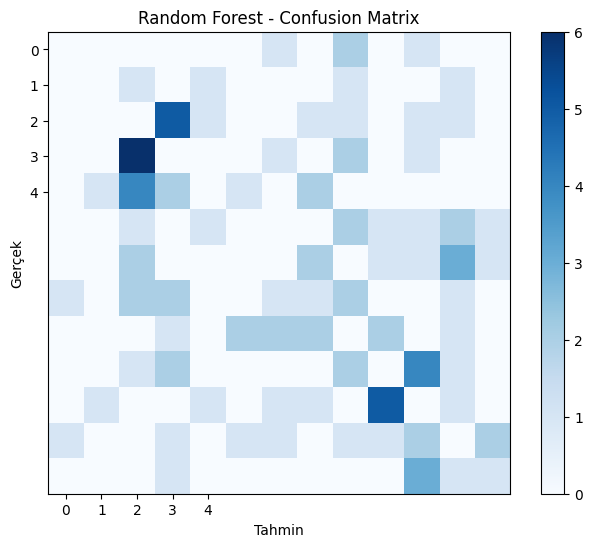

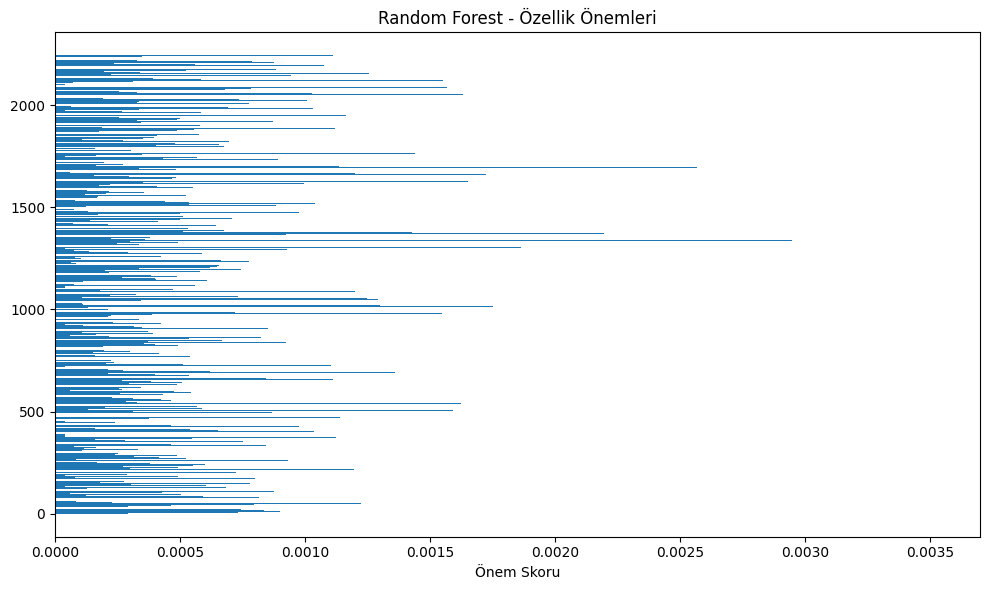


XGBoost Performans:
Accuracy: 0.0796
Macro F1: 0.0768
Cohen's Kappa: -0.0059
Sınıflandırma Raporu:
Sınıflandırma Raporu:
              precision    recall  f1-score   support

        ibeg       0.00      0.00      0.00         4
        iend       0.00      0.00      0.00         4
        rsrt       0.10      0.10      0.10        10
        fixl       0.00      0.00      0.00        10
        quiz       0.00      0.00      0.00        10
        qdon       0.25      0.11      0.15         9
        base       0.25      0.20      0.22        10
        bend       0.07      0.10      0.08        10
        trno       0.08      0.10      0.09        10
        fixL       0.00      0.00      0.00        10
         stm       0.00      0.00      0.00        10
        clic       0.12      0.20      0.15        10
        vlnc       0.25      0.17      0.20         6

    accuracy                           0.08       113
   macro avg       0.09      0.08      0.08       113
weighted avg

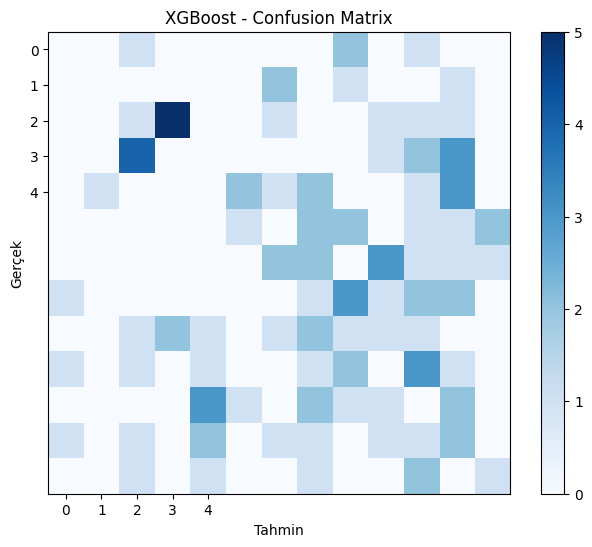

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.0604 - loss: 3.7125 - val_accuracy: 0.0943 - val_loss: 3.7084
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1067 - loss: 3.7073 - val_accuracy: 0.0755 - val_loss: 3.7035
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0704 - loss: 3.7023 - val_accuracy: 0.0755 - val_loss: 3.6986
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.0834 - loss: 3.6973 - val_accuracy: 0.0755 - val_loss: 3.6937
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.0730 - loss: 3.6923 - val_accuracy: 0.0755 - val_loss: 3.6889
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0834 - loss: 3.6873 - val_accuracy: 0.0755 - val_loss: 3.6840
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0938 - loss: 3.6823 - val_accuracy: 0.0755 - val_loss: 3.6792
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0767 - loss: 3.6774 - val_accuracy: 0.0755 - val_loss: 3.6745

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

LSTM Performans:
Accuracy: 0.0885
Macro F1: 0.0125
Cohen's Kappa: 0.0000
Sınıflandırma Raporu:
Sınıflandırma Raporu:
              precision    recall  f1-score   support

        ibeg       0.00      0.00      0.00         4
        iend       0.00      0.00      0.00         4
        rsrt       0.00      0.00      0.00        10
        fixl       0.00      0.00      0.00        10
        quiz       0.09      1.00      0.16        10
        qdon       0.00      0.00      0.00         9
        base       0.00      0.00      0.00        10
        bend       0.00      0.00      0.00        10
        trno       0.00      0.00      0.00        10
        fixL       0.00      0.00      0.00        10
         stm       0.00      0.00      0.00        10
        clic       0.00      0.00      0.00        10
        vlnc       0.00      0.00      0.00         6

    accuracy                           0.09       113
   macro avg       0.01      0.0

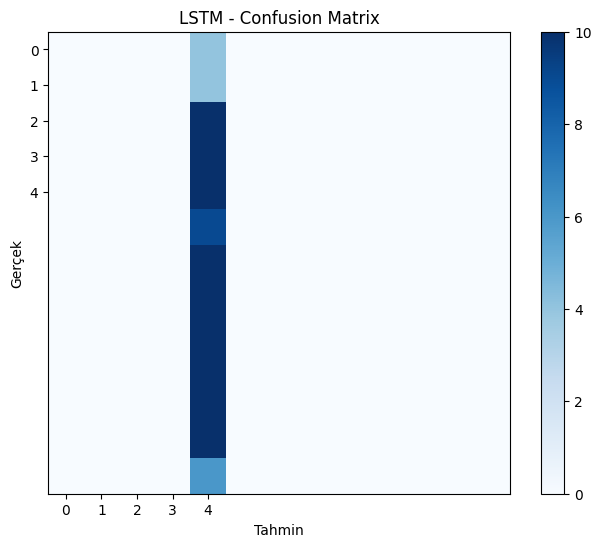

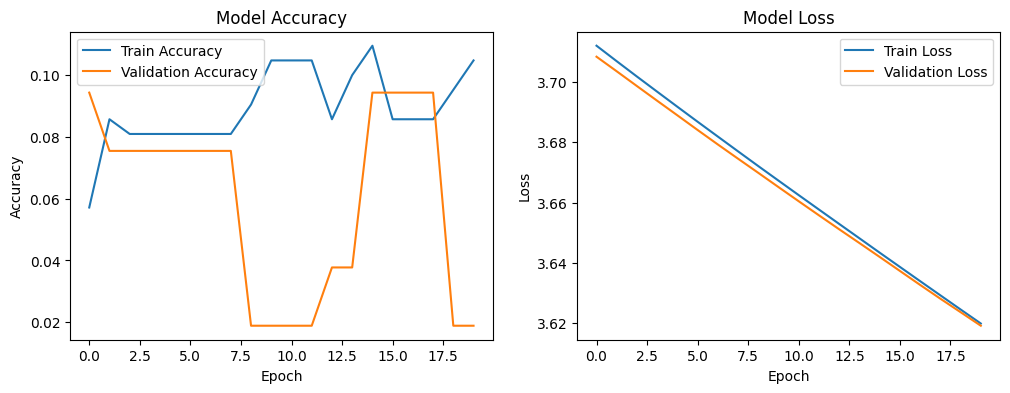

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.0832 - loss: 3.7125 - val_accuracy: 0.0943 - val_loss: 3.7084
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0864 - loss: 3.7074 - val_accuracy: 0.0943 - val_loss: 3.7034
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0853 - loss: 3.7024 - val_accuracy: 0.0943 - val_loss: 3.6985
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0926 - loss: 3.6974 - val_accuracy: 0.0943 - val_loss: 3.6938
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0848 - loss: 3.6924 - val_accuracy: 0.0943 - val_loss: 3.6891
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1062 - loss: 3.6874 - val_accuracy: 0.0943 - val_loss: 3.6844
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0921 - loss: 3.6826 - val_accuracy: 0.0943 - val_loss: 3.6797
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0916 - loss: 3.6776 - val_accuracy: 0.0943 - val_loss: 3.6750


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

MLP Performans:
Accuracy: 0.0885
Macro F1: 0.0125
Cohen's Kappa: 0.0000
Sınıflandırma Raporu:
Sınıflandırma Raporu:
              precision    recall  f1-score   support

        ibeg       0.00      0.00      0.00         4
        iend       0.00      0.00      0.00         4
        rsrt       0.00      0.00      0.00        10
        fixl       0.00      0.00      0.00        10
        quiz       0.00      0.00      0.00        10
        qdon       0.00      0.00      0.00         9
        base       0.00      0.00      0.00        10
        bend       0.00      0.00      0.00        10
        trno       0.00      0.00      0.00        10
        fixL       0.00      0.00      0.00        10
         stm       0.09      1.00      0.16        10
        clic       0.00      0.00      0.00        10
        vlnc       0.00      0.00      0.00         6

    accuracy                           0.09       113
   macro avg       0.01      0.08

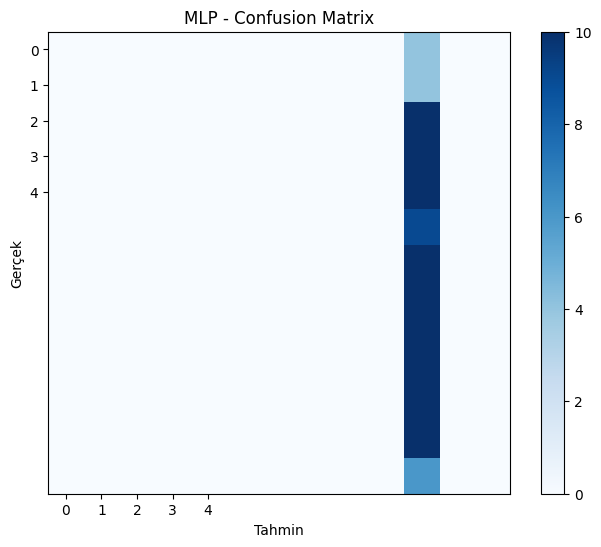

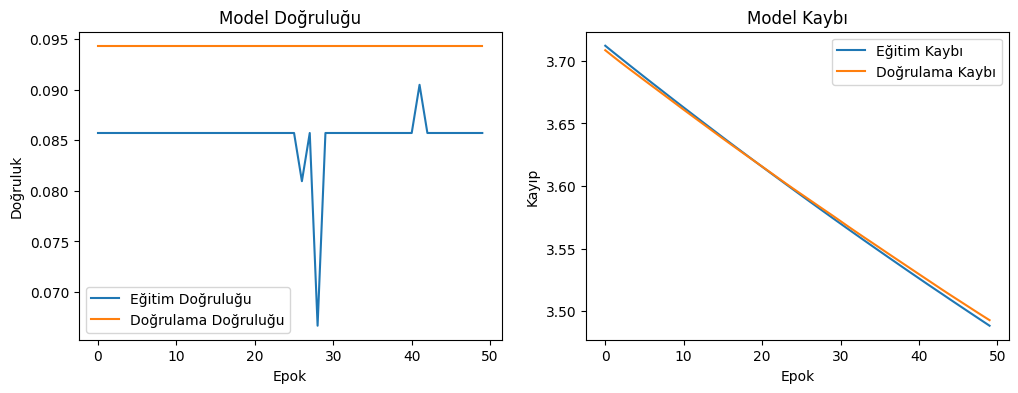


MODEL PERFORMANS KARŞILAŞTIRMASI:
RF: Accuracy=0.017699115044247787, F1=0.02208317997791682, Kappa=-0.07324377513476521
XGB: Accuracy=0.07964601769911504, F1=0.0768045344968422, Kappa=-0.005906017290079557
LSTM: Accuracy=0.08849557522123894, F1=0.012507817385866166, Kappa=0.0
MLP: Accuracy=0.08849557522123894, F1=0.012507817385866166, Kappa=0.0
Modeller başarıyla kaydedildi!


In [40]:

def main():

    DATA_DIR = "./Emotion_EDF_Training_Data"                                                        # Egitim verisinin oldugu yer.
    
    file_pairs = load_emotion_data(DATA_DIR)                                                        # Duygu verisini okuyoruz.
    print(f"Found {len(file_pairs)} (raw, annots) pairs:")
    for raw_path, annot_path in file_pairs:
        print("  ", raw_path, annot_path)
    X, y = create_emotion_dataset(file_pairs, epoch_duration=2.0)                                   # Modelin verisetini cikartiyoruz.
    
    print(f"Oluşturulan veri seti boyutu: {X.shape}")
    print(f"Sınıf dağılımı: {pd.Series(y).value_counts()}")

    counts = pd.Series(y).value_counts()                                                            # Nadir classlari cikarmam gerekti cunku egitimde hata veriyordu.
    valid_classes = counts[counts > 10].index
    mask = np.isin(y, valid_classes)
    X_filtered = X[mask]
    y_filtered = y[mask]

    X_filtered = my_standard_scaler(X_filtered)                                                     # Veriyi olceklendiriyoruz.

    X_train, X_test, y_train, y_test = train_test_split(                                            # Egitim ve test verisini ayiriyoruz.
        X_filtered, y_filtered, test_size=0.3, random_state=42, stratify=y_filtered
    )

    train_classes = np.unique(y_train)                                                              # Sadece train'de olan class'lar testte kalsin dedim cunku yine hata aliyordum.
    test_mask = np.isin(y_test, train_classes)
    X_test = X_test[test_mask]
    y_test = y_test[test_mask]

    from sklearn.preprocessing import LabelEncoder                                                  # Labellari yeniden indeksledim.
    le = LabelEncoder()
    all_labels = np.concatenate([y_train, y_test])
    le.fit(all_labels)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)

    rf_model,rf_results = train_rf_model(X_train, y_train_enc, X_test, y_test_enc)                  # Modelleri egitiyoruz ve degerlendiriyoruz.
    xgb_model,xgb_results = train_xgb_model(X_train, y_train_enc, X_test, y_test_enc)
    lstm_model,lstm_results = train_lstm_model(X_train, y_train_enc, X_test, y_test_enc)
    mlp_model,mlp_results = train_mlp_model(X_train, y_train_enc, X_test, y_test_enc)

    rf_acc, rf_f1, rf_kappa = rf_results
    xgb_acc, xgb_f1, xgb_kappa = xgb_results
    lstm_acc, lstm_f1, lstm_kappa = lstm_results
    mlp_acc, mlp_f1, mlp_kappa = mlp_results
    print("\nMODEL PERFORMANS KARŞILAŞTIRMASI:")                                                    # En sonda toplu performans karsilastirmasi yapiyoruz.
    print(f"RF: Accuracy={rf_acc}, F1={rf_f1}, Kappa={rf_kappa}")
    print(f"XGB: Accuracy={xgb_acc}, F1={xgb_f1}, Kappa={xgb_kappa}")
    print(f"LSTM: Accuracy={lstm_acc}, F1={lstm_f1}, Kappa={lstm_kappa}")
    print(f"MLP: Accuracy={mlp_acc}, F1={mlp_f1}, Kappa={mlp_kappa}")


    import joblib                                                                                   # Egittigimiz modelleri kaydediyoruz.
    from tensorflow.keras.models import save_model
    

    joblib.dump(rf_model, 'random_forest_model.joblib')
    joblib.dump(xgb_model, 'xgboost_model.joblib')
    

    lstm_model.save('lstm_model.h5')
    mlp_model.save('mlp_model.h5')
    
    joblib.dump(le, 'label_encoder.joblib')
    print("Modeller başarıyla kaydedildi!")

if __name__ == "__main__":
    main()